In [51]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn import svm
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from sklearn.model_selection import KFold

# Load dataset
df = pd.read_csv("../../train.csv")
X = df["Text"].values
y = df["Category"].values
m = 0.9 #proportion of data for training vs validation
X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=m, random_state=42, shuffle=True)

### Task 2

SVM. Train two SVM classification models (soft-margin linear SVM and hard-margin RBF
kernel SVM) on the training dataset. You need to report two surface plots for: (i) the soft-margin
linear SVM with your choice of misclassification penalty (𝐶𝐶), and (ii) the hard-margin RBF kernel
with your choice of kernel width (σ). Explain the impact of penalty 𝐶𝐶 on the soft-margin decision
boundaries, as well as the kernel hyperparameter on the hard-margin decision boundaries

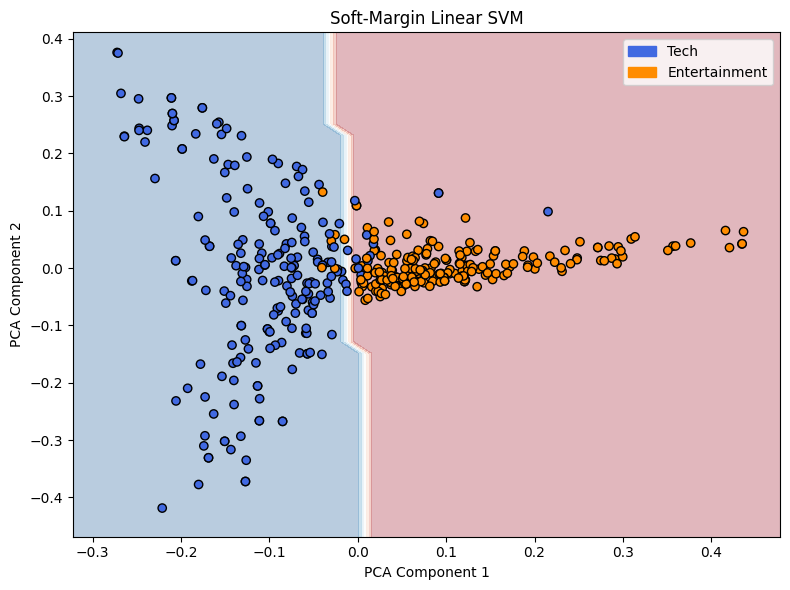

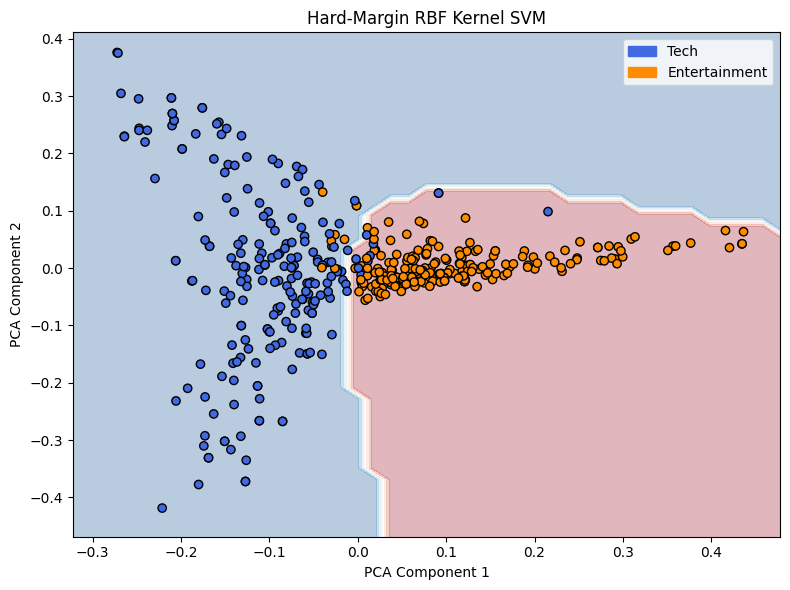

In [52]:
def main():
    # Step 1: Vectorise
    vectorizer = TfidfVectorizer()
    X_vec = vectorizer.fit_transform(X)

    # Step 2: Reduce to 2D BEFORE training
    pca = PCA(n_components=2)
    X_2D = pca.fit_transform(X_vec.toarray())  # <- this is now your 2D training data

    # Step 3: Train SVMs on the 2D data
    model_soft = svm.SVC(kernel='linear', C=1)
    model_soft.fit(X_2D, y)

    model_hard = svm.SVC(kernel='rbf', C=1000, gamma=1)
    model_hard.fit(X_2D, y)

    # Step 4: Plot decision boundaries (on same 2D data)
    plot_decision_boundary(model_soft, X_2D, y, "Soft-Margin Linear SVM")
    plot_decision_boundary(model_hard, X_2D, y, "Hard-Margin RBF Kernel SVM")

def plot_decision_boundary(model, X_2D, y, title):
    h = 0.02
    padding = 0.05
    x_min, x_max = X_2D[:, 0].min() - padding, X_2D[:, 0].max() + padding
    y_min, y_max = X_2D[:, 1].min() - padding, X_2D[:, 1].max() + padding

    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    # Predict directly in 2D space
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z_numeric = pd.factorize(Z)[0].reshape(xx.shape)

    y_numeric, class_names = pd.factorize(y)
    colours = ['royalblue' if label == 0 else 'darkorange' for label in y_numeric]

    plt.figure(figsize=(8, 6))
    plt.contourf(xx, yy, Z_numeric, cmap=plt.cm.RdBu_r, alpha=0.3)
    plt.scatter(X_2D[:, 0], X_2D[:, 1], c=colours, edgecolors='k')

    plt.legend(handles=[
        mpatches.Patch(color='royalblue', label=class_names[0].capitalize()),
        mpatches.Patch(color='darkorange', label=class_names[1].capitalize())
    ])

    plt.title(title)
    plt.xlabel("X1")
    plt.ylabel("X2")
    plt.tight_layout()
    plt.show()

main()


Impact of Pentalty C on Soft-Margin Decision Boundaries: The penalty C will determine how much of a pentalty is applied to a misclassification. This controls the trade off between having a wide margin and minimising misclassifications. Choosing a small C will result in the classifier creating a wider margin but it will have more misclassifications. Choosing a large C will generate a smaller margin and less misclassifications as there is a larger penalty for misclassifications. Smaller C values can be used to help generalise better if the data is noisy or not linearly seperable, however, it can underfit the data. Large C values will fit the training data more tightly due to the higher penalty. This could result in the model overfitting to the training data and not generalising well on unseen data. 


Impact of Kernel Width on Hard-Margin Decision Boundaries: The kernel width determines how much influence each training point has on the classifier. Choosing a small kernel width will cause a smooth, broad decision boundary. This is due to each data point having a large influence, this can cause the model to underfit on more complex patterns. Choosing a large kernel width will result in a tighter more jagged boundary because the data points have less influence. This can cause the model to be more sensitive and overfit.


### Task 3

(a) We explore how the size of the training data set affects the test and train accuracy. For each
value of m in [0.1, 0.3, 0.5, 0.7, 0.9], train your classifier on the first m portion of the training
examples (that is, use the data given by XTrain[0:mN] and yTrain[0:mN]). Please report two
plots: (i) training and (ii) testing accuracy for each such value of m with the x-axis referring to m
and the y-axis referring to the classification accuracy in 𝐹1 measure as shown below. In total,
there should be four curves for training accuracy and four curves for testing accuracy. Explain
the general trend of the two plots in terms of training and testing accuracy if any.

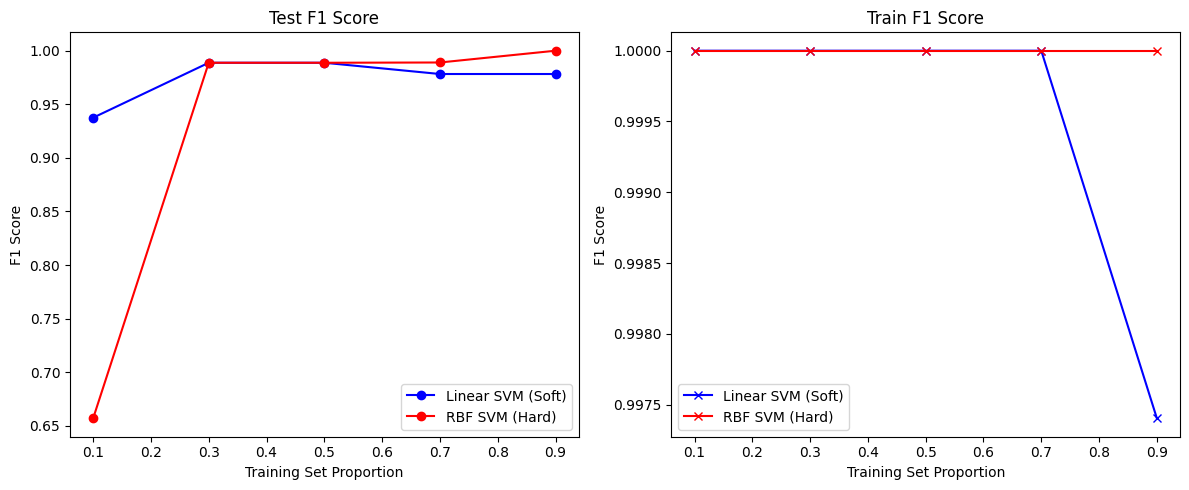

In [53]:
def train_on_m(train_y, vector, vector_test, m, y_test, kernel_type = 'linear'):
    sub_vector = vector[0:round(vector.shape[0]*m)]
    y_sub = train_y[0:round(len(train_y)*m)]
    
    clf = make_classifier(sub_vector, y_sub, kernel_type)
    
    preds_test = clf.predict(vector_test)
    preds_train = clf.predict(sub_vector)
    
    train_f1 = calc_f1(preds_train, y_sub)
    test_f1 = calc_f1(preds_test, y_test)
    return train_f1, test_f1

def calc_f1(preds, actual):
    tp = 0
    fp = 0
    fn = 0
    tn = 0
# tech is positive
    for i in range(len(preds)):
        if preds[i] == "tech" and actual[i] == "tech":
            tp += 1
        elif preds[i] == "tech" and actual[i] == "entertainment":
            fp += 1
        elif preds[i] == "entertainment" and actual[i] == "entertainment":
            tn += 1
        else:
            fn += 1
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f1 = 2*((precision*recall) / (precision+recall))

    return f1

def make_classifier(X, y, kernel_type='linear'):
    if kernel_type == 'linear':
        clf = svm.SVC(kernel = 'linear', C = 1)
    elif kernel_type == 'rbf':
        clf = svm.SVC(kernel = 'rbf', C = 1000, gamma = 1)
    clf.fit(X, y)
    return clf

def main2():
    data = pd.read_csv("../../train.csv")
    y = data["Category"]
    test_data = pd.read_csv("../../test.csv")
    y_test = test_data["Category"]
    
    vector, vector_test = vectorize(data, test_data)

    ms = [0.1, 0.3, 0.5, 0.7, 0.9]
    lin_train_f1s = []
    lin_test_f1s = []
    rbf_train_f1s = []
    rbf_test_f1s = []

    for m in ms:
        lin_train, lin_test = train_on_m(y, vector, vector_test, m, y_test, kernel_type = 'linear')
        rbf_train, rbf_test = train_on_m(y, vector, vector_test, m, y_test, kernel_type = 'rbf')
        lin_train_f1s.append(lin_train)
        lin_test_f1s.append(lin_test)
        rbf_train_f1s.append(rbf_train)
        rbf_test_f1s.append(rbf_test)

    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # Test F1
    axes[0].plot(ms, lin_test_f1s, label="Linear SVM (Soft)", marker="o", color="blue")
    axes[0].plot(ms, rbf_test_f1s, label="RBF SVM (Hard)", marker="o", color="red")
    axes[0].set_title("Test F1 Score")
    axes[0].set_xlabel("Training Set Proportion")
    axes[0].set_ylabel("F1 Score")
    axes[0].legend()

    # Train F1
    axes[1].plot(ms, lin_train_f1s, label="Linear SVM (Soft)", marker="x", color="blue")
    axes[1].plot(ms, rbf_train_f1s, label="RBF SVM (Hard)", marker="x", color="red")
    axes[1].set_title("Train F1 Score")
    axes[1].set_xlabel("Training Set Proportion")
    axes[1].set_ylabel("F1 Score")
    axes[1].legend()

    plt.tight_layout()
    plt.show()

main2()


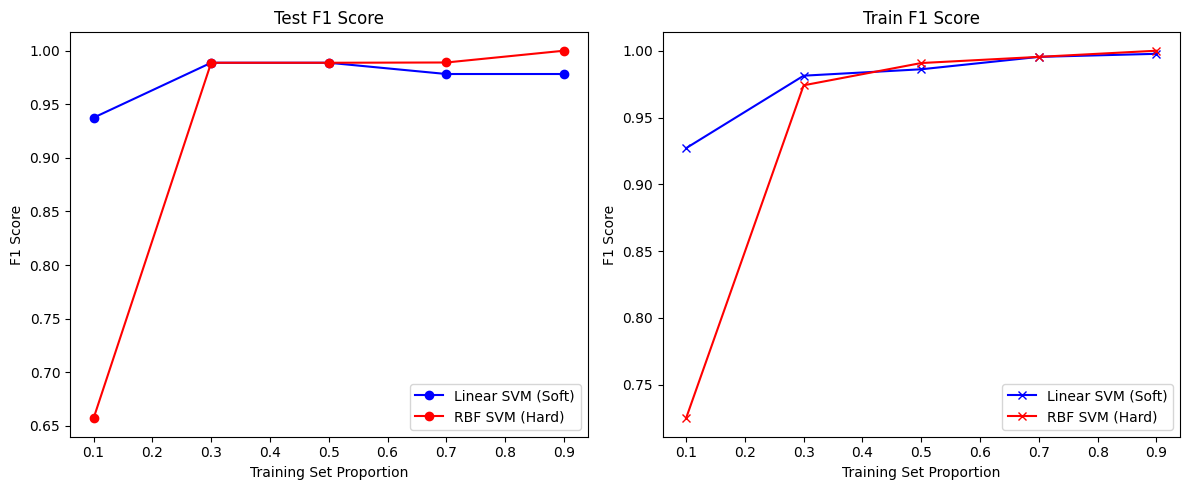

In [54]:
def train_on_m(train_y, vector, vector_test, m, y_test, kernel_type = 'linear'):
    sub_vector = vector[0:round(vector.shape[0]*m)]
    y_sub = train_y[0:round(len(train_y)*m)]
    
    clf = make_classifier(sub_vector, y_sub, kernel_type)
    
    preds_test = clf.predict(vector_test)
    preds_train = clf.predict(vector)
    
    train_f1 = calc_f1(preds_train, train_y)
    test_f1 = calc_f1(preds_test, y_test)
    return train_f1, test_f1

def calc_f1(preds, actual):
    tp = 0
    fp = 0
    fn = 0
    tn = 0
# tech is positive
    for i in range(len(preds)):
        if preds[i] == "tech" and actual[i] == "tech":
            tp += 1
        elif preds[i] == "tech" and actual[i] == "entertainment":
            fp += 1
        elif preds[i] == "entertainment" and actual[i] == "entertainment":
            tn += 1
        else:
            fn += 1
    precision = tp / (tp + fp) if tp+fp >0 else 0
    recall = tp / (tp + fn) if tp+fn >0 else 0
    f1 = 2*((precision*recall) / (precision+recall)) if precision+recall > 0 else 0

    return f1

def vectorize(data, test_data):
    vectorizer = TfidfVectorizer()
    vectorizer.fit(data["Text"])
    vector = vectorizer.transform(data["Text"])
    test_vector = vectorizer.transform(test_data["Text"])
    return vector, test_vector

def make_classifier(X, y, kernel_type='linear'):
    if kernel_type == 'linear':
        clf = svm.SVC(kernel = 'linear', C = 1)
    elif kernel_type == 'rbf':
        clf = svm.SVC(kernel = 'rbf', C = 1000, gamma = 1)
    clf.fit(X, y)
    return clf

def main():
    data = pd.read_csv("../../train.csv")
    y = data["Category"]
    test_data = pd.read_csv("../../test.csv")
    y_test = test_data["Category"]
    vector, vector_test = vectorize(data, test_data)

    ms = [0.1, 0.3, 0.5, 0.7, 0.9]
    lin_train_f1s = []
    lin_test_f1s = []
    rbf_train_f1s = []
    rbf_test_f1s = []

    for m in ms:
        lin_train, lin_test = train_on_m(y, vector, vector_test, m, y_test, kernel_type = 'linear')
        rbf_train, rbf_test = train_on_m(y, vector, vector_test, m, y_test, kernel_type = 'rbf')
        lin_train_f1s.append(lin_train)
        lin_test_f1s.append(lin_test)
        rbf_train_f1s.append(rbf_train)
        rbf_test_f1s.append(rbf_test)

    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # Test F1
    axes[0].plot(ms, lin_test_f1s, label="Linear SVM (Soft)", marker="o", color="blue")
    axes[0].plot(ms, rbf_test_f1s, label="RBF SVM (Hard)", marker="o", color="red")
    axes[0].set_title("Test F1 Score")
    axes[0].set_xlabel("Training Set Proportion")
    axes[0].set_ylabel("F1 Score")
    axes[0].legend()

    # Train F1
    axes[1].plot(ms, lin_train_f1s, label="Linear SVM (Soft)", marker="x", color="blue")
    axes[1].plot(ms, rbf_train_f1s, label="RBF SVM (Hard)", marker="x", color="red")
    axes[1].set_title("Train F1 Score")
    axes[1].set_xlabel("Training Set Proportion")
    axes[1].set_ylabel("F1 Score")
    axes[1].legend()

    plt.tight_layout()
    plt.show()

main()


(b) Let’s use 5-fold cross-validation to assess model performance. Investigate the impact of key
hyperparameters of your choices for each classifier using a testing dataset. E.g., for SVM, the
classification accuracy may be significantly affected by the kernels and hyperparameter
combination. List hyperparameters for each classifier and demonstrate how these
hyperparameters impact on the testing accuracy.

In [57]:
df = pd.read_csv("../../train.csv")
X = df["Text"]
y = df["Category"]

# Define hyperparameter values to try
kernels = ['linear', 'rbf']
C = [0.1, 0.5, 1, 5, 10]
kernel_width = [0.1, 0.5, 1, 5, 10]


kf = KFold(n_splits=5, shuffle=True, random_state=42)

results = []

for kernel in kernels:
    if kernel == 'linear':
        for cs in C:
            for train_index, val_index in kf.split(X):
                X_train_fold, X_val_fold = X.iloc[train_index], X.iloc[val_index]
                y_train_fold, y_val_fold = y.iloc[train_index], y.iloc[val_index]

                # Vectorize
                vectorizer = TfidfVectorizer()

                X_train_vec = vectorizer.fit_transform(X_train_fold)
                X_val_vec = vectorizer.transform(X_val_fold)

                clf = svm.SVC(kernel = kernel, C = cs)
                clf.fit(X_train_vec, y_train_fold)

                # Predict and evaluate
                y_pred = clf.predict(X_val_vec)
                f1 = calc_f1(list(y_pred), list(y_val_fold))
                f1_scores.append(f1)

            avg_f1 = np.mean(f1_scores)
            results.append({
                "kernels": kernel,
                "C": cs,
                "f1_score": avg_f1
            })

    else: 
        for width in kernel_width:
            f1_scores = []

            for train_index, val_index in kf.split(X):
                X_train_fold, X_val_fold = X.iloc[train_index], X.iloc[val_index]
                y_train_fold, y_val_fold = y.iloc[train_index], y.iloc[val_index]

                # Vectorize
                vectorizer = TfidfVectorizer()

                X_train_vec = vectorizer.fit_transform(X_train_fold)
                X_val_vec = vectorizer.transform(X_val_fold)

                clf = svm.SVC(kernel=kernel, C = cs, gamma = width)
                clf.fit(X_train_vec, y_train_fold)

                # Predict and evaluate
                y_pred = clf.predict(X_val_vec)
                f1 = calc_f1(list(y_pred), list(y_val_fold))
                f1_scores.append(f1)

            avg_f1 = np.mean(f1_scores)
            results.append({
                "kernels": kernel,
                "kernel_width": width,
                "f1_score": avg_f1
            })

# Sort and display
results = sorted(results, key=lambda x: x['f1_score'], reverse=True)
for result in results:
    if result['kernels'] == 'linear':
        print(f"Kernel: {result['kernels']}, C: {result['C']}, F1 Score: {result['f1_score']:.4f}")
    else:
        print(f"Kernel: {result['kernels']}, Kernel Width: {result['kernel_width']}, F1 Score: {result['f1_score']:.4f}")
    

Kernel: rbf, Kernel Width: 0.1, F1 Score: 0.9860
Kernel: rbf, Kernel Width: 0.5, F1 Score: 0.9860
Kernel: rbf, Kernel Width: 1, F1 Score: 0.9860
Kernel: linear, C: 10, F1 Score: 0.9489
Kernel: linear, C: 5, F1 Score: 0.9414
Kernel: linear, C: 1, F1 Score: 0.9303
Kernel: linear, C: 0.5, F1 Score: 0.9117
Kernel: linear, C: 0.1, F1 Score: 0.8734
Kernel: rbf, Kernel Width: 5, F1 Score: 0.5058
Kernel: rbf, Kernel Width: 10, F1 Score: 0.3977
